In [2]:
%autosave 120

Autosaving every 120 seconds


In [8]:
import pandas as pd
import spacy
#pip install nltk
from nltk.tokenize import word_tokenize
import numpy as np
import en_core_web_sm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
from sklearn.linear_model import SGDClassifier

# Load data

In [2]:
train = pd.read_csv('train copy.csv')
X_train = train.iloc[:5000,].comment_text

In [7]:
X_train.shape

(5000,)

# Pre-process the text

In [3]:
def preprocess(corpus):
    '''This pre-processing function lemmatizes words, makes a commment case-insensitive, removes punctuation,
    removes stop words and removes single characters. '''
    
    # convert df to list; *corpus* is of a form of a list of str
    corpus = corpus.to_list()
    
    # initialize lemmatizer and a list of stopwords
    lemmatizer = spacy.load('en', disable = ['parser', 'ner'])
    #lemmatizer = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    all_stopwords = lemmatizer.Defaults.stop_words
    
    for i in range(len(corpus)):
        text = corpus[i] # one comment
        
        # convert text to lower case
        text = text.lower()
        
        # remove punctuations and numbers but save the "'"
        symbols = "—…,!\"#$%&()*+-./:;<=>?@[\]^_`{|}~0123456789"
        for sym in symbols:
            text = np.char.replace(text, sym, ' ') # replace symbols by one space

        # tokenize text
        text_tokens = word_tokenize(str(text))
        
        # remove stop words ("sw") and single characters
        tokens_without_sw = " ".join([word for word in text_tokens if (word not in all_stopwords) and (len(word) > 1)])

        # remove "’"
        tokens_without_sw = np.char.replace(tokens_without_sw, "'", ' ')
        
        # spaCy Lemmatization
        doc = lemmatizer(str(tokens_without_sw))
        corpus[i] = " ".join([token.lemma_ for token in doc]) # Extract the lemma for each token and join
    return corpus

In [4]:
X_train_tidy = preprocess(X_train)
X_train_tidy

['cool like   would want mother read great idea',
 'thank life lot anxiety induce let way',
 'urgent design problem kudo take impressive',
 'able install site release',
 'haha guy bunch loser',
 'ur sh tty comment',
 'hahahahahahahahhha suck',
 'ffffuuuuuuuuuuuuuuu',
 'rancher motivated greed right allow animal destroy public land',
 'great combo expect good',
 'wow sound great',
 'great story man wonder person yell shut fuck hear',
 'like step right direction',
 'ridiculous guy call protester armed threat violence make terrorist',
 'story get ridiculous hour love people send guy dildos mail think happy end think delude joke assume',
 'agree want grant legitimacy protestor greedy small minded people share mass delusion good idea individual right thing rancher large basically currently belong select group people profit',
 'interesting curious work refrain comment time desire engage couple resident troll jump active ww comment thread',
 'awesome love civil comment',
 'glad working look f

In [5]:
train['label'] = np.where(train['target'] < 0.5, 0, 1)
y_train = train.iloc[:5000,].label

In [208]:
'''
    cited from scikit-learn...
    Using pipeline and grid search to tune parameters of vectorization, feature selection and model fitting. 
'''
pipeline = Pipeline([
                    ('vect', CountVectorizer(stop_words='english')), 
                    ('kbest', SelectKBest()), 
    # why mutual_info_classif, not f_classifier: https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c
                     ('clf', SGDClassifier(random_state=100)), 
                    ])
parameters={
    'vect__ngram_range': ((1, 1), (1, 2)), 
    'kbest__score_func': (mutual_info_classif, chi2, f_classif),
    'kbest__k': (1000,2000,'all'),
    #'clf__alpha': [1e-7, 1e0],
    #'clf__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    # C / alpha overfits or not.
    'clf__penalty': ('l2', 'l1'), #l2: ridge regression
    'clf__loss': ('hinge', 'log') #hinge (Default): a linear SVM, log: logistic regression
    
}

if __name__ == '__main__':
    grid_search=GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    
    grid_search.fit(X_train_tidy, y_train)
    
    print("done in %0.3fs" % (time() - t0))
    print()
    
    results = grid_search.cv_results_
    test_scores = results['mean_test_score']
    params = results['params']
    rank = results['rank_test_score']
    
    print("best score: %0.3f" % grid_search.best_score_)
    best_parameters = grid_search.best_estimator_.get_params()
    print("Best parameters set: ")
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print("Top 5 best parameter sets based on accuracy score: ")
    list(np.take(params,list(rank.argsort()[:5])))
    

Performing grid search...
pipeline: ['vect', 'kbest', 'clf']
parameters:
{'clf__loss': ('hinge', 'log'),
 'clf__penalty': ('l2', 'l1'),
 'kbest__k': (1000, 2000, 'all'),
 'kbest__score_func': (<function mutual_info_classif at 0x1264009d8>,
                       <function chi2 at 0x1261c1158>,
                       <function f_classif at 0x1261c1048>),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 64.3min finished


done in 3856.768s

best score: 0.957
Best parameters set: 
	clf__loss: 'log'
	clf__penalty: 'l1'
	kbest__k: 2000
	kbest__score_func: <function f_classif at 0x1261c1048>
	vect__ngram_range: (1, 2)
Top 5 best parameter sets based on accuracy score: 


In [ ]:
# the parameter sets that gives the highest accuracy score
grid_search.best_params_

In [219]:
# the top three parameter sets have similar accuracy
np.take(test_scores, list(rank.argsort()[:5]))

array([0.94 , 0.944, 0.944, 0.932, 0.921])

In [209]:
results = grid_search.cv_results_
test_scores = results['mean_test_score']
params = results['params']
rank = results['rank_test_score']
print("Top 5 best parameter sets based on accuracy score: ")
list(np.take(params,list(rank.argsort()[:5])))

[{'clf__loss': 'log',
  'clf__penalty': 'l1',
  'kbest__k': 2000,
  'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
  'vect__ngram_range': (1, 2)},
 {'clf__loss': 'log',
  'clf__penalty': 'l1',
  'kbest__k': 1000,
  'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
  'vect__ngram_range': (1, 2)},
 {'clf__loss': 'log',
  'clf__penalty': 'l2',
  'kbest__k': 1000,
  'kbest__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
  'vect__ngram_range': (1, 2)},
 {'clf__loss': 'log',
  'clf__penalty': 'l2',
  'kbest__k': 1000,
  'kbest__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
  'vect__ngram_range': (1, 2)},
 {'clf__loss': 'log',
  'clf__penalty': 'l2',
  'kbest__k': 2000,
  'kbest__score_func': <function sklearn.feature_selection._mutual_info

In [216]:
# calcuate train & test accuracy using tuned parameters
vectorizer = CountVectorizer(stop_words='english')
X_train_tidy_vec = vectorizer.fit_transform(X_train_tidy)

vocab_train1, vocab_val1, y_vocab_train1, y_vocab_val1 = train_test_split(X_train_tidy_vec, y_train, test_size=0.3, random_state = 100)

fs = SelectKBest(score_func=mutual_info_classif, k=1000)
fs_train = fs.fit(vocab_train1, y_vocab_train)
transformer_train = fs.transform(vocab_train1)
transformer_val = fs.transform(vocab_val1)

sgd_clf = SGDClassifier(loss='log', penalty='l1').fit(transformer_train, y_vocab_train1)
print("Accuracy after parameter tunning: ")
print("train accuracy: ", cross_val_score(sgd_clf, transformer_train, y_vocab_train1).mean())
print("test accuracy: ", cross_val_score(sgd_clf, transformer_val, y_vocab_val1).mean())

Accuracy after parameter tunning: 
train accuracy:  0.9514285714285714
test accuracy:  0.9299999999999999


/Users/sophiezheng/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=alpha, param_range=[1.00000000e-15 2.02358965e-15 4.09491506e-15 8.28642773e-15
 1.67683294e-14 3.39322177e-14 6.86648845e-14 1.38949549e-13
 2.81176870e-13 5.68986603e-13 1.15139540e-12 2.32995181e-12
 4.71486636e-12 9.54095476e-12 1.93069773e-11 3.90693994e-11
 7.90604321e-11 1.59985872e-10 3.23745754e-10 6.55128557e-10
 1.32571137e-09 2.68269580e-09 5.42867544e-09 1.09854114e-08
 2.22299648e-08 4.49843267e-08 9.10298178e-08 1.84206997e-07
 3.72759372e-07 7.54312006e-07 1.52641797e-06 3.08884360e-06
 6.25055193e-06 1.26485522e-05 2.55954792e-05 5.17947468e-05
 1.04811313e-04 2.12095089e-04 4.29193426e-04 8.68511374e-04
 1.75751062e-03 3.55648031e-03 7.19685673e-03 1.45634848e-02
 2.94705170e-02 5.96362332e-02 1.20679264e-01 2.44205309e-01
 4.94171336e-01 1.00000000e+00] as keyword args. From version 0.25 passing these as positional arguments will result in an error


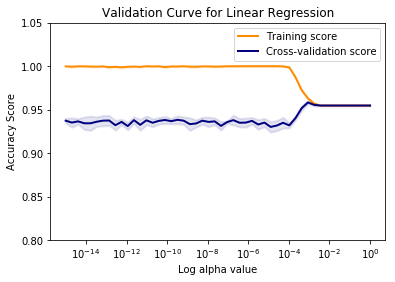

best log alpha value: 0.000868511373751352


In [218]:
'''
    Source: scikit-learn... , 
    Validation curve shows the accuracy score of using different regularization parameter values
'''
from sklearn.model_selection import validation_curve, learning_curve
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
train_scores, test_scores = validation_curve(SGDClassifier(loss='log', penalty='l1'), 
                                             X_train_tidy_vec, y_train, "alpha", 
                                             np.logspace(-15, 0, 50),
                                             cv = 5, n_jobs=-1, verbose=10)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

param_range = np.logspace(-15, 0, 50)
plt.title("Validation Curve for Linear Regression")
plt.xlabel("Log alpha value")
plt.ylabel("Accuracy Score")
plt.ylim(0.8, 1.05)
lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# finding the value C with the highest validation accuracy score
best_alpha = param_range[test_scores_mean.argmax()]
print("best log alpha value:", best_alpha)

[learning_curve] Training set sizes: [   1   81  163  244  326  408  489  571  653  734  816  897  979 1061
 1142 1224 1306 1387 1469 1551 1632 1714 1795 1877 1959 2040 2122 2204
 2285 2367 2448 2530 2612 2693 2775 2857 2938 3020 3102 3183 3265 3346
 3428 3510 3591 3673 3755 3836 3918 4000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of 250 | elapsed:    3.4s remaining:   46.4s
[Parallel(n_jobs=-1)]: Done  43 out of 250 | elapsed:    3.8s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  69 out of 250 | elapsed:    4.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  95 out of 250 | elapsed:    4.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 121 out of 250 | elapsed:    4.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done 147 out of 250 | elapsed:    4.7s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 173 out of 250 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 199 out of 250 | elapsed:    5.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 225 out of 250 | elapsed:    5.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.0s finished


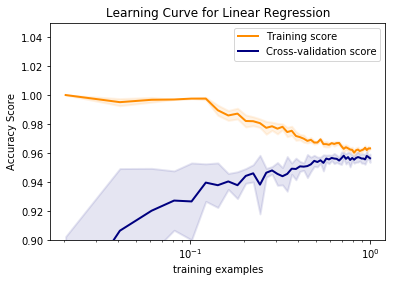

In [217]:
'''
    Code cited from scikit-learn/Plotting Learning Curves... 
    Learning curve is plotted to show how well a model can learn from the data. 
    Closer the validation score is to the training score, better the model is. 
'''
train_size, learn_train, learn_test = learning_curve(SGDClassifier(loss='log', penalty='l1', alpha = best_alpha),  
                                                    X_train_tidy_vec, y_train, 
                                                    train_sizes = np.linspace(0.00001,1,50), 
                                                    cv = 5, n_jobs=-1, verbose=10)
mean_learn_train = np.mean(learn_train, axis=1)
std_learn_train = np.std(learn_train, axis=1)
mean_learn_test = np.mean(learn_test, axis=1)
std_learn_test = np.std(learn_test, axis=1)

train_sizes = np.linspace(0.000001,1,50)
plt.title("Learning Curve for Linear Regression")
plt.xlabel("training examples")
plt.ylabel("Accuracy Score")
plt.ylim(0.9, 1.05)
lw = 2

plt.plot(train_sizes, mean_learn_train, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(train_sizes, mean_learn_train - std_learn_train,
                 mean_learn_train + std_learn_train, alpha=0.1,
                 color="darkorange", lw=lw)
plt.semilogx(train_sizes, mean_learn_test, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(train_sizes, mean_learn_test - std_learn_test,
                 mean_learn_test + std_learn_test, alpha=0.1,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, 
    grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
